# Utilities

In [3]:
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
import matplotlib as mpl
from scipy.integrate import odeint
from numpy import linalg as LA
from scipy.optimize import fsolve
from scipy.optimize import curve_fit
mpl.rcdefaults() 
from scipy.stats import uniform
import scipy.stats as st
from matplotlib import colors
from matplotlib import cm
import pandas as pd
import datetime
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cartopy.crs as ccrs
import cartopy
import json
import xarray as xr
import pickle
from scipy.stats import linregress
from EWS_functions import *
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d

jtplot.style(context='paper', fscale=1.4, spines=True, grid=False, ticks=True,gridlines='--')

fontsize=16
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True

mpl.rcParams['font.size'] = 16
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'
mpl.rcParams['axes.labelsize']= 'x-large'
mpl.rcParams['figure.facecolor']='white'

mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial']
hfont = {'fontname':'Arial'}

mpl.rcParams['text.latex.preamble']= r'\usepackage{amsmath}'
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d','#666666']) 

## EWS plot functions

In [4]:
def get_EWS(time,data,trend,ws):
    linfits = []
    ps = []
    bound = ws // 2
    
    std = runstd(data - trend, ws)[bound:-bound]
    p0, p1 = np.polyfit(time[bound : -bound][:-2], std[:-2], 1)
    linfits.append([p0,p1])
    ps.append(kendall_tau_test(std[:-2], 1000, p0))
    
    ar1 = runac(data - trend, ws)[bound : -bound]
    p0, p1 = np.polyfit(time[bound : -bound][:-3], ar1[:-3], 1)
    linfits.append([p0,p1])
    ps.append(kendall_tau_test(ar1[:-2], 1000, p0))
    
    lam = run_fit_a_ar1(data-trend,ws)[bound:-bound]
    p0, p1 = np.polyfit(time[bound : -bound][:-2], lam[:-2], 1)
    linfits.append([p0,p1])
    ps.append(kendall_tau_test(lam[:-2], 1000, p0))
    
    return std, ar1, lam, linfits, ps

In [5]:
def plot_EWS(data, timess, ws=70, col='k',lbl='',alph=1,lw=1):
    bound = ws // 2
    popt, cov = curve_fit(funcfit3, timess, data, p0 = [-8.33097773e-01,  1.05507897e-02,  2.02518923e+03], maxfev = 1000000000)
    trend = funcfit3(timess, *popt)
    std, ar1, lam, linfits, ps = get_EWS(timess,data,trend,ws)

    ax1.plot(timess[bound : -bound],std,color=col,label=lbl,alpha=alph,lw=lw)
    pv = kendall_tau_test(std[:-2],1000,linfits[1][0])
    ax1.plot(timess[bound : -bound][:-2],linfits[0][0] * timess[bound : -bound][:-2] + linfits[0][1],linestyle='--',color=col,alpha=alph,lw=lw,label="p = {:.3f}".format(pv))

    ax2.plot(timess[bound : -bound],ar1,color=col,label=lbl,alpha=alph,lw=lw)
    pv = kendall_tau_test(ar1[:-2],1000,linfits[1][0])
    ax2.plot(timess[bound : -bound][:-2],linfits[1][0] * timess[bound : -bound][:-2] + linfits[1][1],linestyle='--',color=col,alpha=alph,lw=lw,label="p = {:.3f}".format(pv))

    ax3.plot(timess[bound : -bound],lam,color=col,label=lbl,alpha=alph,lw=lw)
    p0, p1, p2 = np.polyfit(timess[bound : -bound][:-2], lam[:-2], 2)
    pl0, pl1  = np.polyfit(timess[bound : -bound][:-2], lam[:-2], 1)
    pv = kendall_tau_test(lam[:-2], 1000, pl0) # precentile of 1000 fourier surrogates have a larger linear slope
#     ax3.plot(timess[bound : -bound][:-2], p0 * timess[bound : -bound][:-2]**2+p1 * timess[bound : -bound][:-2] + p2, color=col,linestyle='--',alpha=alph,lw=lw,label="p = {:.3f}".format(pv))
    ax3.plot(timess[bound : -bound][:-2], pl0 * timess[bound : -bound][:-2] + pl1, color=col,linestyle='--',alpha=alph,lw=lw,label="p = {:.3f}".format(pv))

# files

In [6]:
ds = xr.open_dataset('DAMIP_amoc.nc')
damip_strn = ds.amoc_damip.sel(latitudes='26.5N')
damip_index = ds.index_damip

In [7]:
aer = xr.open_dataarray('hist_aer_amoc_index.nc').groupby('time.year').mean('time')
nat = xr.open_dataarray('hist_nat_amoc_index.nc').groupby('time.year').mean('time')
ghg = xr.open_dataarray('hist_ghg_amoc_index.nc').groupby('time.year').mean('time')

In [8]:
ds = xr.open_dataset('CMIP6_amoc.nc')
strn26 = ds.strength_265N
strn35 = ds.strength_35N
index = ds.index
hist_cesm2 = index.sel(models='CESM2')

# get ECS data

ECS data source: https://github.com/mzelinka/cmip56_forcing_feedback_ecs

In [9]:
import json
f = open('CMIP6_ECS.json','r')
data = json.load(f)

In [10]:
models = list(data['CMIP6'].keys())

In [11]:
ECSs = []
for model in models:
    ens = list(data['CMIP6'][model].keys())[0]
    ecs = data['CMIP6'][model][ens]['ECS']
    ECSs.append(ecs)

In [12]:
M20_ECSs = []
M20_Emodels = []
for i, model in enumerate(strn26.models.values):
    try:
        ens = list(data['CMIP6'][model].keys())[0]
        ecs = data['CMIP6'][model][ens]['ECS']
        M20_Emodels.append(model)
        M20_ECSs.append(ecs)
    except:
        print(model)
M20_ECSs = np.array(M20_ECSs)
M20_Emodels = np.array(M20_Emodels)

idcs = np.where(M20_ECSs>=4.5)
lECS_models = M20_Emodels[idcs]
idcs = np.where(M20_ECSs<4.5)
sECS_models = M20_Emodels[idcs]

E3SM-1-1
FIO-ESM-2-0
NorESM1-F
GFDL-AM4


# lambda

In [13]:
# lambdas = xr.open_dataset('EWS_files/CMIP6_lambdas.nc')
# lambda_pvs = xr.open_dataset('EWS_files/CMIP6_lambda_pvs.nc')
# lambda_trends = xr.open_dataset('EWS_files/CMIP6_lambda_trends.nc')

In [18]:
ds = xr.open_dataset('new_EWS/CMIP6_lam_pvs_w50.nc')
lambdas = ds.lambdas
lambda_pvs = ds.taus

In [16]:
damip_lambda_pvs = xr.open_dataset('EWS_files/DAMIP_lambda_pvs.nc')


# CMIP6

In [20]:
min_pvs = 0.05
EWS_all =pvs.where(
           ((pvs.sel(indices='strn26')<=min_pv)&
            (pvs.sel(indices='strn35')<=min_pv)&
            (pvs.sel(indices='index')<=min_pv)))
EWS_strn26 =pvs.sel(indices='strn26').where(
           (pvs.sel(indices='strn26')<=min_pv))
EWS_strn35 =pvs.sel(indices='strn35').where(
           (pvs.sel(indices='strn35')<=min_pv))
EWS_index =pvs.sel(indices='index').where(
           (pvs.sel(indices='index')<=min_pv))

In [19]:
min_pv = 0.05

EWS_all = lambda_pvs.where(
           ((lambda_pvs.strn26_pvs<=min_pv)&
            (lambda_pvs.strn35_pvs<=min_pv)&
            (lambda_pvs.index_pvs<=min_pv)))
EWS_strn26 = lambda_pvs.where(
           (lambda_pvs.strn26_pvs<=min_pv))
EWS_strn35 = lambda_pvs.where(
           (lambda_pvs.strn35_pvs<=min_pv))
EWS_index = lambda_pvs.where(
           (lambda_pvs.index_pvs<=min_pv))

EWS_any = lambda_pvs.where(
           ((lambda_pvs.strn26_pvs<=min_pv) |
            (lambda_pvs.strn35_pvs<=min_pv) |
            (lambda_pvs.index_pvs<=min_pv)))
EWS_strns = lambda_pvs.where(
           (lambda_pvs.strn26_pvs<=min_pv)&
            (lambda_pvs.strn35_pvs<=min_pv))
EWS_strn35indx = lambda_pvs.where(
           (lambda_pvs.strn35_pvs<=min_pv)&
            (lambda_pvs.index_pvs<=min_pv))
EWS_strn26indx = lambda_pvs.where(
           (lambda_pvs.strn26_pvs<=min_pv)&
            (lambda_pvs.index_pvs<=min_pv))

AttributeError: 'DataArray' object has no attribute 'strn26_pvs'

In [21]:
yrs = strn26.year.values
strn26_trend = np.zeros((34,10))
for imod in range(34):
    for iens in range(10):
        amc = np.nan_to_num(strn26.values[imod,iens,:])
        slope, intercept, r, p, se = linregress(yrs, amc)
        strn26_trend[imod,iens]=slope*100 # trend of Sv/century
index_trend = np.zeros((34,10))
for imod in range(34):
    for iens in range(10):
        idx = np.nan_to_num(index.values[imod,iens,:])
        slope, intercept, r, p, se = linregress(yrs, idx)
        index_trend[imod,iens]=slope*100 # trend of Sv/century
strn35_trend = np.zeros((34,10))
for imod in range(34):
    for iens in range(10):
        amc = np.nan_to_num(strn35.values[imod,iens,:])
        slope, intercept, r, p, se = linregress(yrs, amc)
        strn35_trend[imod,iens]=slope*100 # trend of Sv/century

In [32]:
def get_ratios(EWS,strn, strn_trend):
    Ni = np.count_nonzero(~np.isnan(EWS.where(strn_trend>=0).values))
    Ni_tot = np.count_nonzero(~np.isnan(strn.mean(dim='year').where(strn_trend>=0).values))
    Nd = np.count_nonzero(~np.isnan(EWS.where(strn_trend<0).values))
    Nd_tot = np.count_nonzero(~np.isnan(strn.mean(dim='year').where(strn_trend<0).values))
    
    Nb = np.count_nonzero(~np.isnan(EWS.sel(models=bistable).values))
    Nb_tot = np.count_nonzero(~np.isnan(strn.sel(models=bistable).mean(dim='year').values))
    Nm = np.count_nonzero(~np.isnan(EWS.sel(models=known_monostable).values))
    Nm_tot = np.count_nonzero(~np.isnan(strn.sel(models=known_monostable).mean(dim='year').values))
    Nn = np.count_nonzero(~np.isnan(EWS.sel(models=not_nahosmip).values))
    Nn_tot = np.count_nonzero(~np.isnan(strn.sel(models=not_nahosmip).mean(dim='year').values))
    
    Nl = np.count_nonzero(~np.isnan(EWS.sel(models=lECS_models).values))
    Nl_tot = np.count_nonzero(~np.isnan(strn.sel(models=lECS_models).mean(dim='year').values))
    Ns = np.count_nonzero(~np.isnan(EWS.sel(models=sECS_models).values))
    Ns_tot = np.count_nonzero(~np.isnan(strn.sel(models=sECS_models).mean(dim='year').values))
    
    Na = np.count_nonzero(~np.isnan(EWS.values))
    Na_tot = np.count_nonzero(~np.isnan(strn.mean(dim='year').values))
    
    return [Ni/Ni_tot,Nd/Nd_tot,Nb/Nb_tot,Nm/Nm_tot,Nn/Nn_tot,Nl/Nl_tot,Ns/Ns_tot,Na/Na_tot]

In [33]:
bistable = ['CESM2','CanESM5','HadGEM3-GC31-MM','IPSL-CM6A-LR']
known_monostable = ['HadGEM3-GC31-LL','EC-Earth3','MPI-ESM1-2-HR']
not_nahosmip = ['AWI-CM-1-1-MR', 'BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0',
       'FGOALS-f3-L', 'FGOALS-g3', 'IITM-ESM', 'CNRM-CM6-1',
       'CNRM-CM6-1-HR', 'CNRM-ESM2-1', 'E3SM-1-1', 
       'EC-Earth3-Veg', 'FIO-ESM-2-0', 'INM-CM4-8', 'INM-CM5-0',
        'MIROC6',
       'UKESM1-0-LL', 'MRI-ESM2-0', 'GISS-E2-1-G',
       'CESM2-WACCM', 'NorESM1-F', 'NorESM2-LM', 'GFDL-AM4', 'GFDL-CM4',
       'GFDL-ESM4', 'NESM3', 'SAM0-UNICON']



In [34]:
EWSs = [EWS_strn26,EWS_strn35,EWS_index]
strns = [strn26,strn35,index]
strn_trends = [strn26_trend,strn35_trend,index_trend]

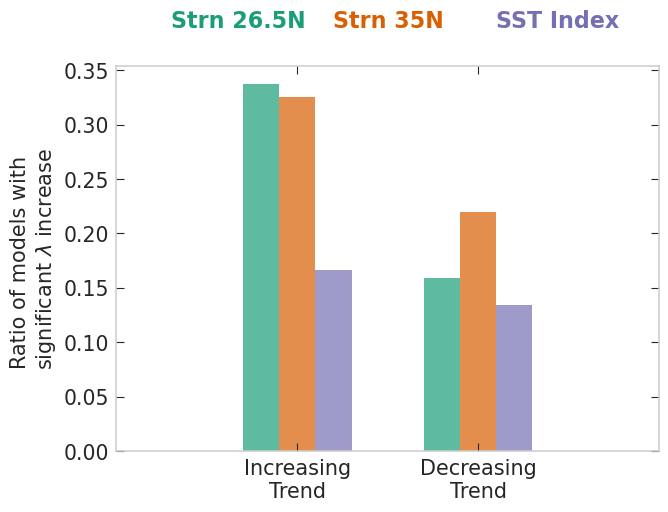

In [37]:

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
tcks = np.array([0.5,1])
cols = [ 'C0','C1','C2']
for i, EWS in enumerate(EWSs):
    strn = strns[i]
    strn_trend = strn_trends[i]
    ratios = get_ratios(EWS,strn,strn_trend)[:2]
    plt.bar(tcks-0.1+0.1*i,ratios,color=cols[i],width=0.1,alpha=0.7)
ax.text(0.1,1.1,'Strn 26.5N',transform=ax.transAxes,fontweight='bold',ma='left',color='C0')
ax.text(0.4,1.1,'Strn 35N',transform=ax.transAxes,fontweight='bold',ma='left',color='C1')
ax.text(0.7,1.1,'SST Index',transform=ax.transAxes,fontweight='bold',ma='left',color='C2')
ax.set_ylabel('Ratio of models with \nsignificant $\lambda$ increase',fontsize=15)
ax.set_xticks([0.5,1])
ax.set_xlim(0,1.5)
ax.set_xticklabels(['Increasing\nTrend','Decreasing\nTrend'],fontsize=15)
plt.show()


fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
tcks = np.array([1,2,4,5,6,8,9,11])
cols = [ 'C0','C2','C3']
for i, EWS in enumerate(EWSs):
    strn = strns[i]
    strn_trend = strn_trends[i]
    ratios = get_ratios(EWS,strn,strn_trend)
    plt.bar(tcks-0.1+0.1*i,ratios,color=cols[i],width=0.1)
ax.text(0.5,1.1,'Strn26',transform=ax.transAxes,fontweight='bold',ma='left',color='C0')
ax.text(0.6,1.1,'Strn35',transform=ax.transAxes,fontweight='bold',ma='left',color='C2')
ax.text(0.7,1.1,'Index',transform=ax.transAxes,fontweight='bold',ma='left',color='C3')
ax.set_ylabel('Ratio of models with significant $\lambda$ increase',fontsize=13)
ax.set_xticks([1,2,4,5,6,8,9,11])
ax.set_xticklabels(['Increasing\nProxy','Decreasing\nProxy','NAHosMIP\nBistable','NAHosMIP\nMonostable','Not in\nNAHosMIP','Large ECS','Small ECS','Total'],fontsize=10)
plt.show()

# DAMIP

In [21]:
damip_ECSs = []
damip_Emodels = []
for i, model in enumerate(damip_strn.models.values):
    try:
        ens = list(data['CMIP6'][model].keys())[0]
        ecs = data['CMIP6'][model][ens]['ECS']
        damip_Emodels.append(model)
        damip_ECSs.append(ecs)
    except:
        print(model)
damip_ECSs = np.array(damip_ECSs)
damip_Emodels = np.array(damip_Emodels)

idcs = np.where(damip_ECSs>=4.5)
damip_lECS_models = damip_Emodels[idcs]
idcs = np.where(damip_ECSs<4.5)
damip_sECS_models = damip_Emodels[idcs]

In [22]:
def get_ratios_damip(EWS,strn, strn_trend):
    Ni = np.count_nonzero(~np.isnan(EWS.where(strn_trend>=0).values))
    Ni_tot = np.count_nonzero(~np.isnan(strn.mean(dim='year').where(strn_trend>=0).values))
    Nd = np.count_nonzero(~np.isnan(EWS.where(strn_trend<0).values))
    Nd_tot = np.count_nonzero(~np.isnan(strn.mean(dim='year').where(strn_trend<0).values))
    
    Nl = np.count_nonzero(~np.isnan(EWS.sel(models=damip_lECS_models).values))
    Nl_tot = np.count_nonzero(~np.isnan(strn.sel(models=damip_lECS_models).mean(dim='year').values))
    Ns = np.count_nonzero(~np.isnan(EWS.sel(models=damip_sECS_models).values))
    Ns_tot = np.count_nonzero(~np.isnan(strn.sel(models=damip_sECS_models).mean(dim='year').values))
    
    Na = np.count_nonzero(~np.isnan(EWS.values))
    Na_tot = np.count_nonzero(~np.isnan(strn.mean(dim='year').values))
    
    return [Ni/Ni_tot,Nd/Nd_tot,Nl/Nl_tot,Ns/Ns_tot,Na/Na_tot]

In [23]:
min_pv = 0.05

damip_EWS_all = damip_lambda_pvs.where(
           ((damip_lambda_pvs.strn26_pvs<=min_pv)&
            (damip_lambda_pvs.strn35_pvs<=min_pv)&
            (damip_lambda_pvs.index_pvs<=min_pv)))
damip_EWS_strn26 = damip_lambda_pvs.where(
           (damip_lambda_pvs.strn26_pvs<=min_pv))
damip_EWS_strn35 = damip_lambda_pvs.where(
           (damip_lambda_pvs.strn35_pvs<=min_pv))
damip_EWS_index = damip_lambda_pvs.where(
           (damip_lambda_pvs.index_pvs<=min_pv))

damip_EWS_any = damip_lambda_pvs.where(
           ((lambda_pvs.strn26_pvs<=min_pv) |
            (lambda_pvs.strn35_pvs<=min_pv) |
            (lambda_pvs.index_pvs<=min_pv)))
damip_EWS_strns = damip_lambda_pvs.where(
           (damip_lambda_pvs.strn26_pvs<=min_pv)&
            (damip_lambda_pvs.strn35_pvs<=min_pv))
damip_EWS_strn35indx = damip_lambda_pvs.where(
           (damip_lambda_pvs.strn35_pvs<=min_pv)&
            (damip_lambda_pvs.index_pvs<=min_pv))
damip_EWS_strn26indx = damip_lambda_pvs.where(
           (damip_lambda_pvs.strn26_pvs<=min_pv)&
            (damip_lambda_pvs.index_pvs<=min_pv))

In [24]:
saer = damip_strn.sel(experiments='hist-aer')
snat = damip_strn.sel(experiments='hist-nat')
sghg = damip_strn.sel(experiments='hist-GHG')
shist = damip_strn.sel(experiments='historical')

iaer = damip_index.sel(experiments='hist-aer')
inat = damip_index.sel(experiments='hist-nat')
ighg = damip_index.sel(experiments='hist-GHG')
ihist = damip_index.sel(experiments='historical')

yrs = damip_strn.year


In [25]:
def get_trend(yrs,data,nmod=7):
    trend = np.zeros((nmod,10))
    for imod in range(nmod):
        for iens in range(10):
            amc = np.nan_to_num(data.values[imod,iens,:])
            slope, intercept, r, p, se = linregress(yrs, amc)
            trend[imod,iens]=slope*100
    return trend

In [26]:
saer_trend = get_trend(yrs,saer)
snat_trend = get_trend(yrs,snat)
sghg_trend = get_trend(yrs,sghg)
shist_trend = get_trend(yrs,shist)
iaer_trend = get_trend(yrs,iaer)
inat_trend = get_trend(yrs,inat)
ighg_trend = get_trend(yrs,ighg)
ihist_trend = get_trend(yrs,ihist)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


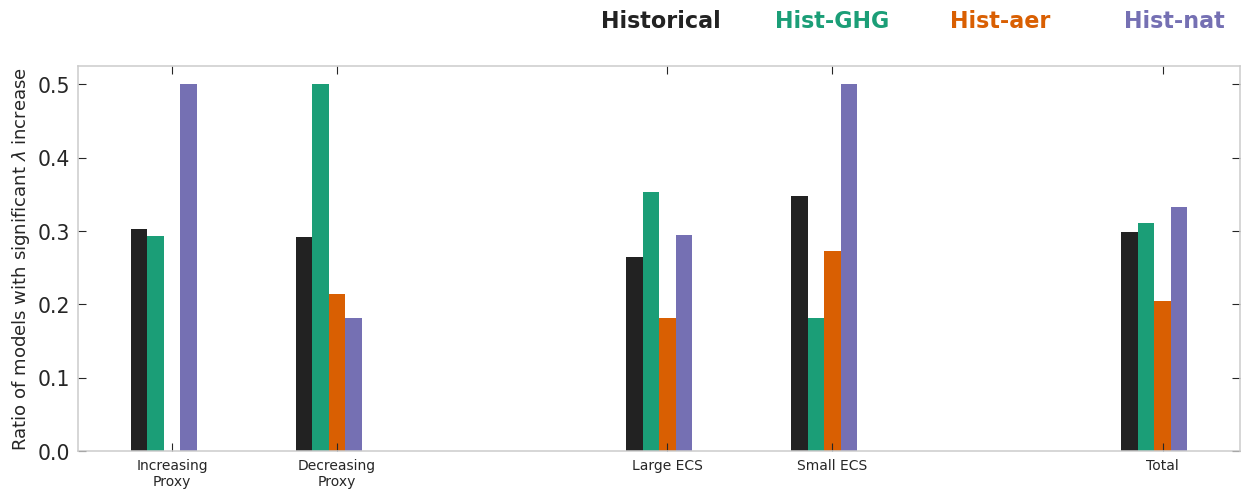

In [27]:
experiments = ['historical', 'hist-aer', 'hist-GHG', 'hist-nat']
strn_trends = [shist_trend,saer_trend,sghg_trend,snat_trend]
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
tcks = np.array([1,2,4,5,7])
cols = [ 'k','C0','C1','C2']
for i, exp in enumerate(experiments):
    EWS = damip_EWS_strn26.strn26_pvs.sel(experiments=exp)
    strn = damip_strn.sel(experiments=exp)
    strn_trend = strn_trends[i]
    ratios = get_ratios_damip(EWS,strn,strn_trend)
    plt.bar(tcks-0.2+0.1*i,ratios,color=cols[i],width=0.1)
ax.text(0.45,1.1,'Historical',transform=ax.transAxes,fontweight='bold',ma='left',color='k')
ax.text(0.6,1.1,'Hist-GHG',transform=ax.transAxes,fontweight='bold',ma='left',color='C0')
ax.text(0.75,1.1,'Hist-aer',transform=ax.transAxes,fontweight='bold',ma='left',color='C1')
ax.text(0.9,1.1,'Hist-nat',transform=ax.transAxes,fontweight='bold',ma='left',color='C2')

ax.set_ylabel('Ratio of models with significant $\lambda$ increase',fontsize=13)
ax.set_xticks(tcks)
ax.set_xticklabels(['Increasing\nProxy','Decreasing\nProxy','Large ECS','Small ECS','Total'],fontsize=10)
plt.show()